# Car object detection

### Introduction
The field of computer vision has made remarkable strides in recent years, revolutionizing industries ranging from autonomous vehicles to security systems. Car object detection, a pivotal subfield of computer vision, has gained increasing significance as it plays a vital role in enhancing road safety, traffic management, and the development of self-driving cars. This project, "Car Object Detection," endeavors to contribute to this dynamic and essential area by leveraging cutting-edge deep learning techniques to accurately detect and track cars in real-time.

### Problem overview
The primary objective of this project is to develop a robust car object detection system capable of accurately identifying and tracking cars within static images. It involves locating cars, determining their positions, and ensuring precise detection while excluding pedestrians. Key aspects of the problem include handling occlusion, achieving high detection accuracy, and distinguishing between vehicles and other objects within the static image. While this project is tailored for static images, it lays the foundation for broader applications such as traffic management, security surveillance, and autonomous navigation.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

from pathlib import Path

In [2]:
#Reading images using Pathh library

train_path = Path("training_images")
test_path = Path("testing_images")

In [3]:
#Reading dataset
train = pd.read_csv("train_solution_bounding_boxes (1).csv")

#converting data types into integer
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

#dropping duplicate rows
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

This code reads a CSV file containing bounding box data for a car object detection project, ensures that the relevant columns have integer data types, and removes duplicate rows based on the 'image' column. This data preprocessing step helps prepare the dataset for further use, such as training a machine learning model for car object detection.

In [4]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

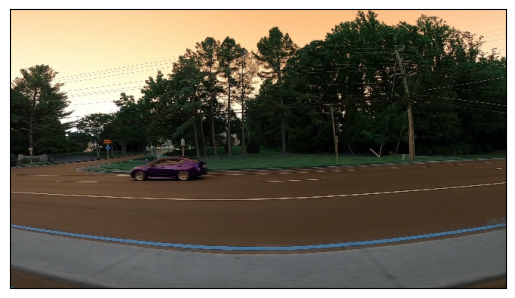

In [5]:
display_image_from_file("vid_4_10500.jpg")

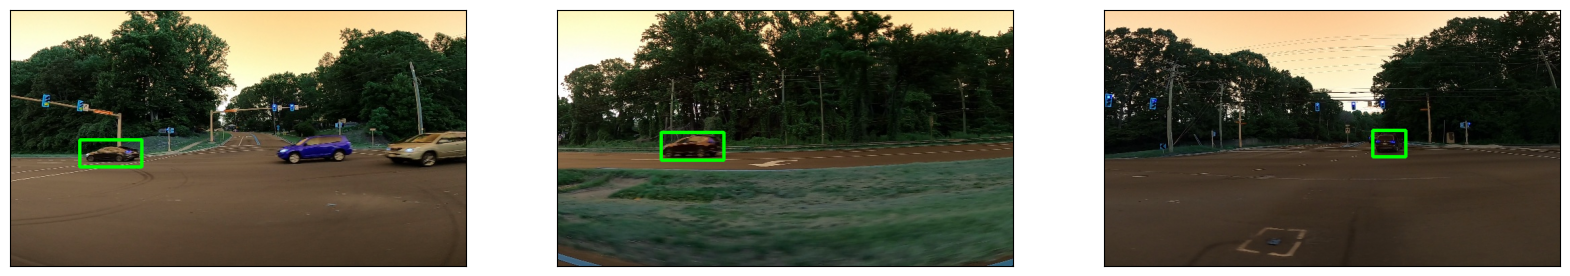

In [6]:
display_grid()

In [7]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}

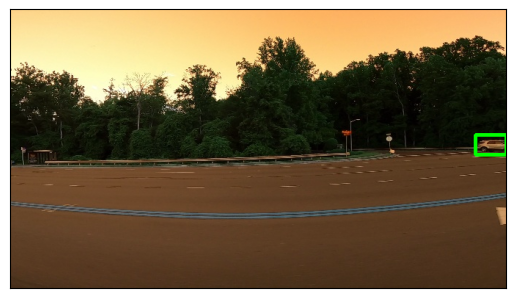

In [8]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

In [9]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 16)      64    

In [10]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [11]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

1/1 [==============================] - 0s 93ms/step


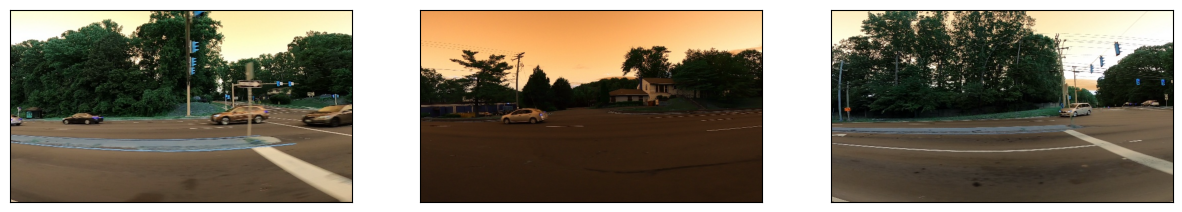

In [12]:
test(model)

Epoch 1/9
1/1 [==============================] - 0s 149ms/step


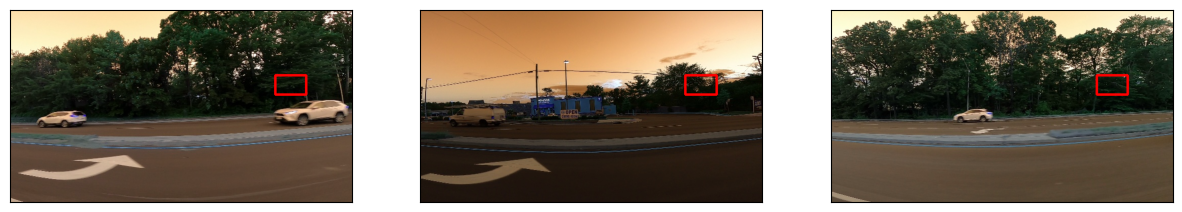

100/100 [==============================] - 882s 9s/step - loss: 15129.5049 - accuracy: 0.6837
Epoch 2/9
1/1 [==============================] - 0s 126ms/step


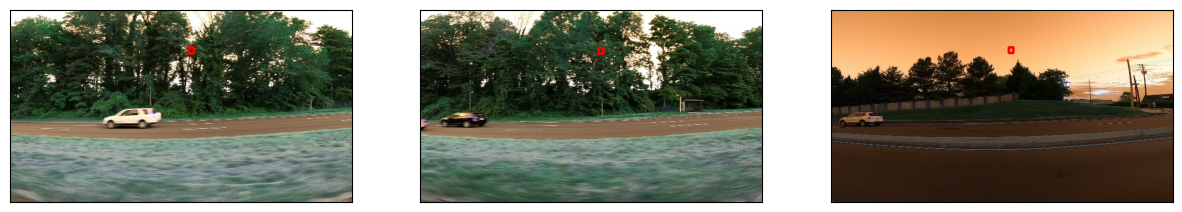

100/100 [==============================] - 763s 8s/step - loss: 2525.5791 - accuracy: 0.9300
Epoch 3/9
1/1 [==============================] - 0s 110ms/step


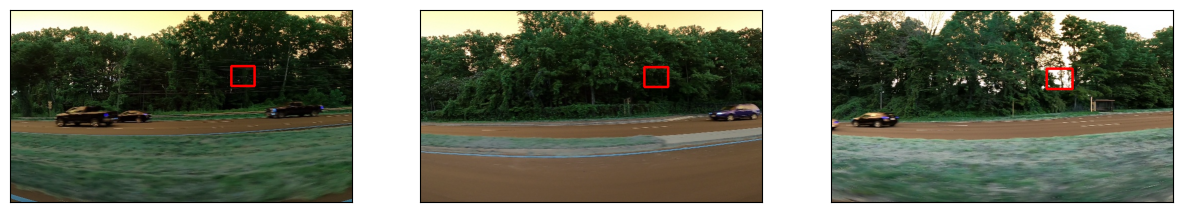

100/100 [==============================] - 767s 8s/step - loss: 2209.7705 - accuracy: 0.9362
Epoch 4/9
1/1 [==============================] - 0s 112ms/step


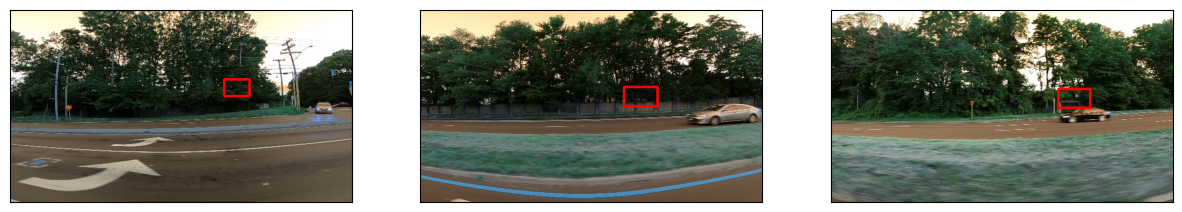

100/100 [==============================] - 788s 8s/step - loss: 1617.2573 - accuracy: 0.9588
Epoch 5/9
1/1 [==============================] - 0s 122ms/step


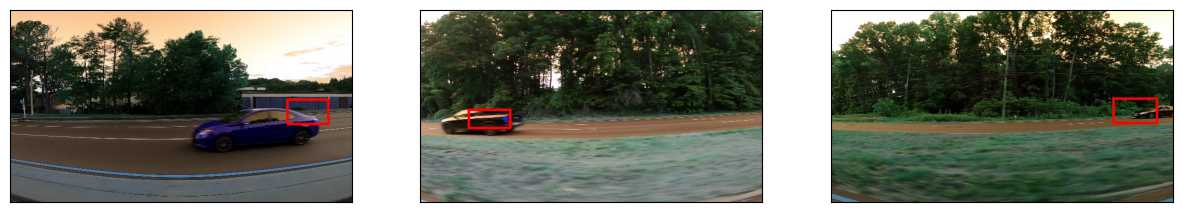

100/100 [==============================] - 753s 8s/step - loss: 1520.6541 - accuracy: 0.9594
Epoch 6/9
1/1 [==============================] - 0s 99ms/step


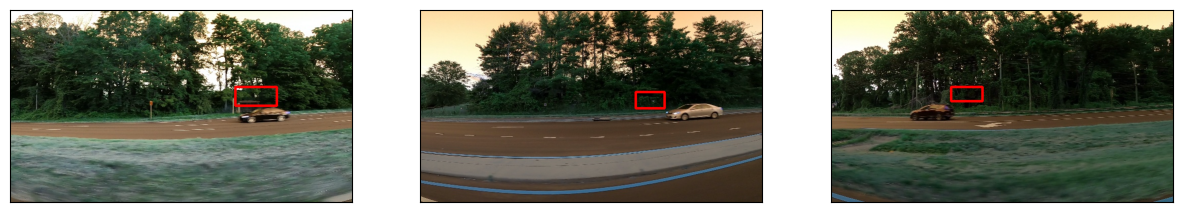

100/100 [==============================] - 737s 7s/step - loss: 1110.4882 - accuracy: 0.9613
Epoch 7/9
1/1 [==============================] - 0s 120ms/step


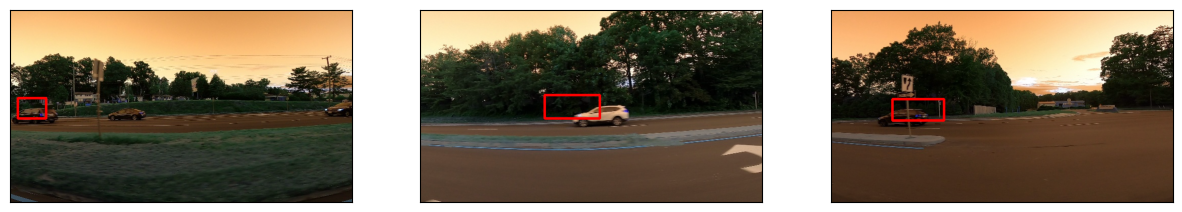

100/100 [==============================] - 733s 7s/step - loss: 1065.9856 - accuracy: 0.9631
Epoch 8/9
1/1 [==============================] - 0s 106ms/step


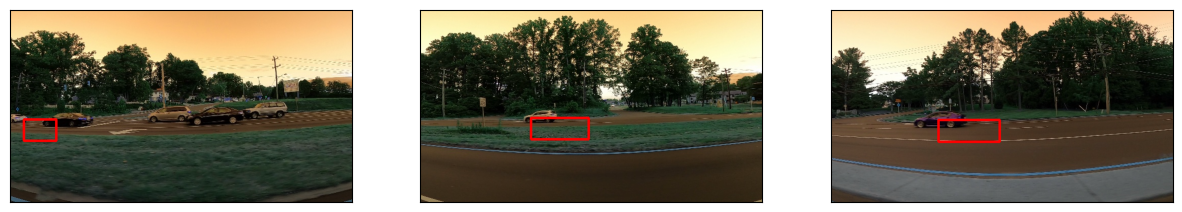

100/100 [==============================] - 715s 7s/step - loss: 841.3127 - accuracy: 0.9581
Epoch 9/9
1/1 [==============================] - 0s 125ms/step


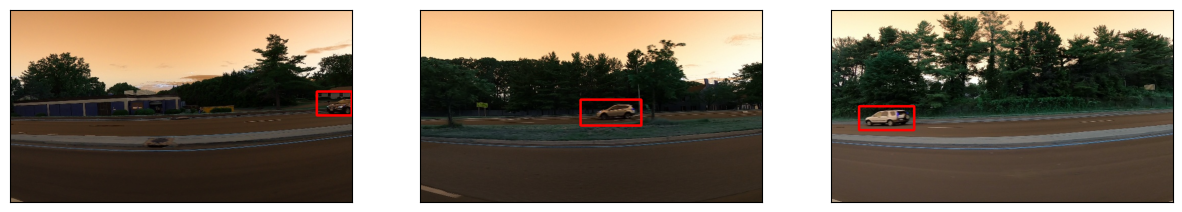

100/100 [==============================] - 721s 7s/step - loss: 483.1786 - accuracy: 0.9737


In [13]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=100,
        callbacks=[
            ShowTestImages(),
        ]
    )